In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['user_id','movie_id','rating','timestamp'])
# u.item 文件共有 24 列：前 5 列是基本信息，后面 19 列是 19 个流派的 0/1 标志
item_cols = ['movie_id','title','release_date','video_release_date','IMDb_URL'] \
            + [f'genre_{i}' for i in range(19)]
movies = pd.read_csv('ml-100k/u.item', sep='|', names=item_cols,
                     encoding='latin-1')

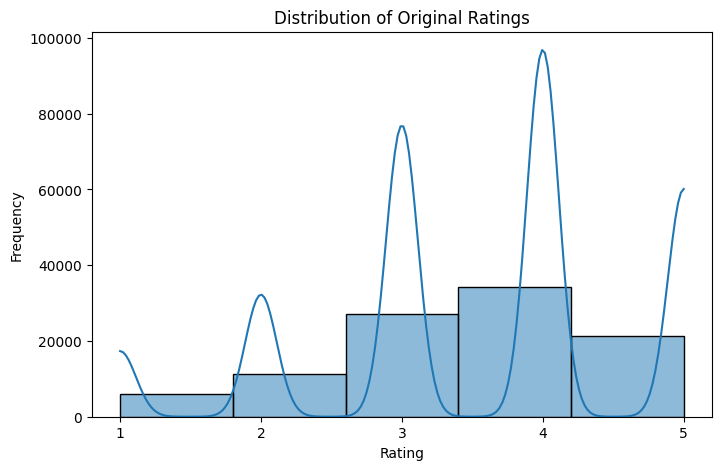

In [16]:
# --- 可视化 1: 原始评分分布 ---
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=5, kde=True)
plt.title('Distribution of Original Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.savefig("images/Distribution of Original Ratings.png")
plt.show()

In [4]:
# 计算每个用户的平均评分
user_means = ratings.groupby('user_id')['rating'].mean()
# 创建中心化后的评分列
ratings['rating_centered'] = ratings.apply(
    lambda r: r['rating'] - user_means.loc[r['user_id']], axis=1)

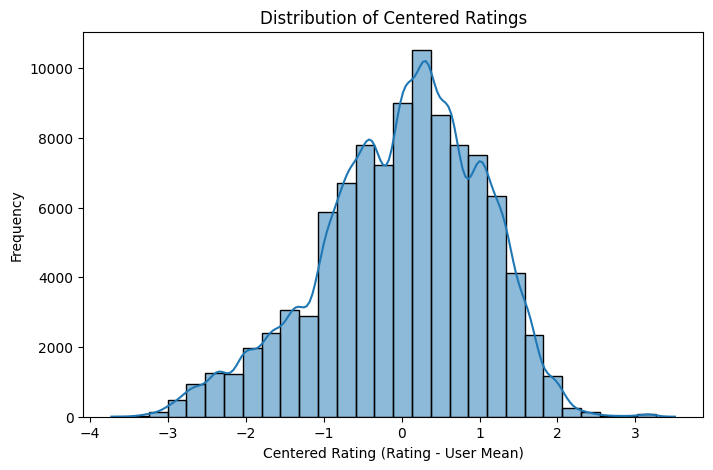

In [17]:
# --- 可视化 2: 中心化评分分布 ---
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating_centered'], bins=30, kde=True) 
plt.title('Distribution of Centered Ratings')
plt.xlabel('Centered Rating (Rating - User Mean)')
plt.ylabel('Frequency')
plt.savefig("images/Distribution of Centered Ratings_2.png")
plt.show()

In [6]:
# ——— 3. 构建电影类型矩阵 ——————————————————————————————————————
genre_cols = item_cols[5:]  # genre_0 … genre_18
movie_genres = movies.set_index('movie_id')[genre_cols]

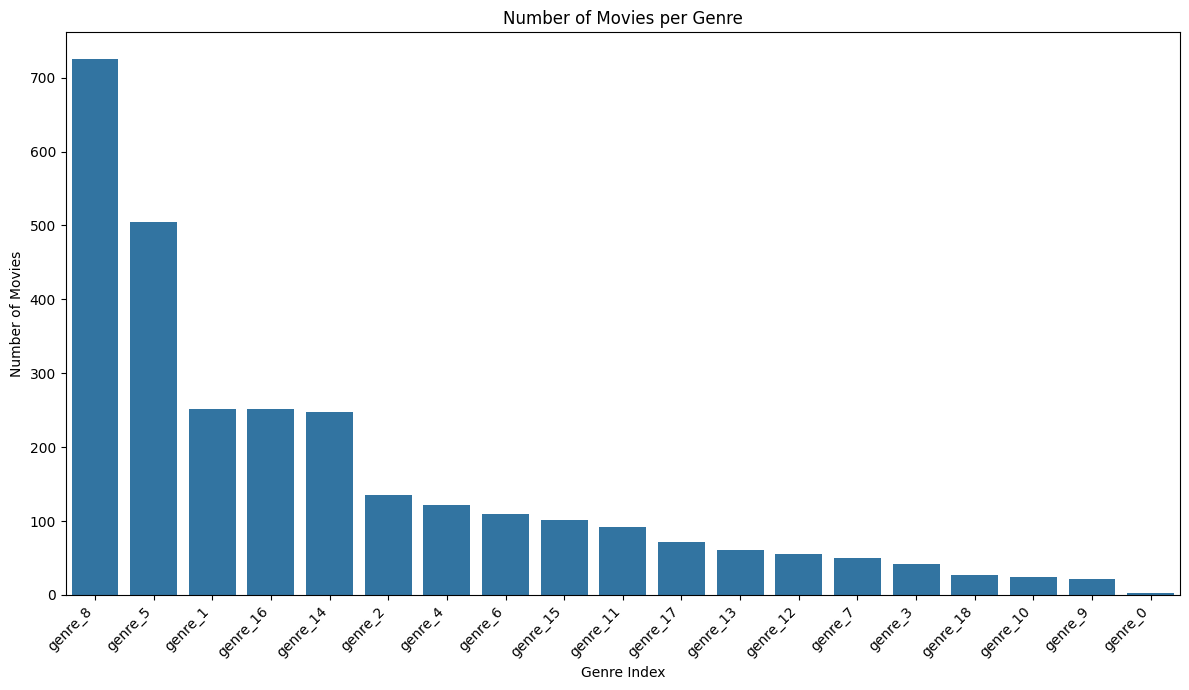

In [18]:
# --- 可视化 3: 电影类型分布 (电影计数) ---
genre_counts = movie_genres.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Number of Movies per Genre')
plt.xlabel('Genre Index') # 这里显示的是 genre_0 到 genre_18，实际含义需要查 u.genre 文件
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right') # 旋转X轴标签，防止重叠
plt.tight_layout() # 调整布局，防止标签被截断
plt.savefig("images/Number of Movies per Genre.png")
plt.show()

In [8]:
# ——— 4. 构建用户画像函数 —————————————————————————————————————
def build_user_profile(user_id):
    # 拿到该用户的所有中心化评分记录
    user_r = ratings[ratings['user_id'] == user_id]
    # 在电影类型矩阵上合并，按“中心化评分”加权
    df = user_r.merge(movie_genres, left_on='movie_id', right_index=True)
    # 对每个类型列做加权求和，得到用户在各类型上的偏好分数
    profile = (df[genre_cols].multiply(df['rating_centered'], axis=0)
                 .sum())
    return profile


In [9]:
# 构建用户画像 (返回 Series)
profile_200_series = build_user_profile(200)
profile_15_series  = build_user_profile(15)

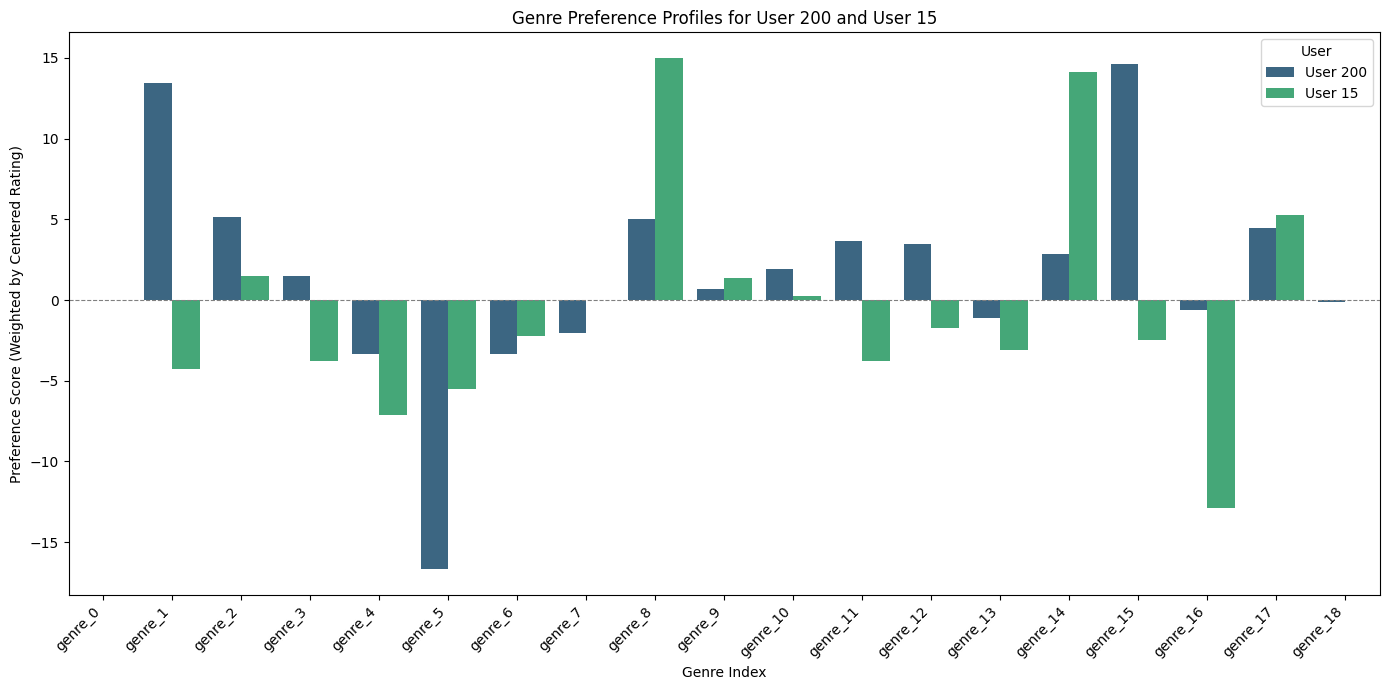

In [21]:
profiles_df = pd.DataFrame({
    'User 200': profile_200_series, # <-- 这里使用的是 Series
    'User 15': profile_15_series    # <-- 这里使用的是 Series
})
profiles_df = profiles_df.reset_index() # 将 Genre 索引变成列
profiles_df = profiles_df.rename(columns={'index': 'Genre'})


# 将数据转换为“长格式”，适合 seaborn 的 barplot
profiles_melted = profiles_df.melt(id_vars='Genre', var_name='User', value_name='Preference Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Genre', y='Preference Score', hue='User', data=profiles_melted, palette='viridis')
plt.title('Genre Preference Profiles for User 200 and User 15')
plt.xlabel('Genre Index')
plt.ylabel('Preference Score (Weighted by Centered Rating)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # 添加一条0线，区分正负偏好
plt.savefig("images/Genre Preference Profiles for User 200 and User 15.png")
plt.show()

In [11]:
# ——— 5. 提取电影 95 的类型向量 ————————————————————————————————
item_95_vec = movie_genres.loc[95].values.reshape(1, -1)
profile_200_vec = profile_200_series.values.reshape(1, -1)
profile_15_vec  = profile_15_series.values.reshape(1, -1)

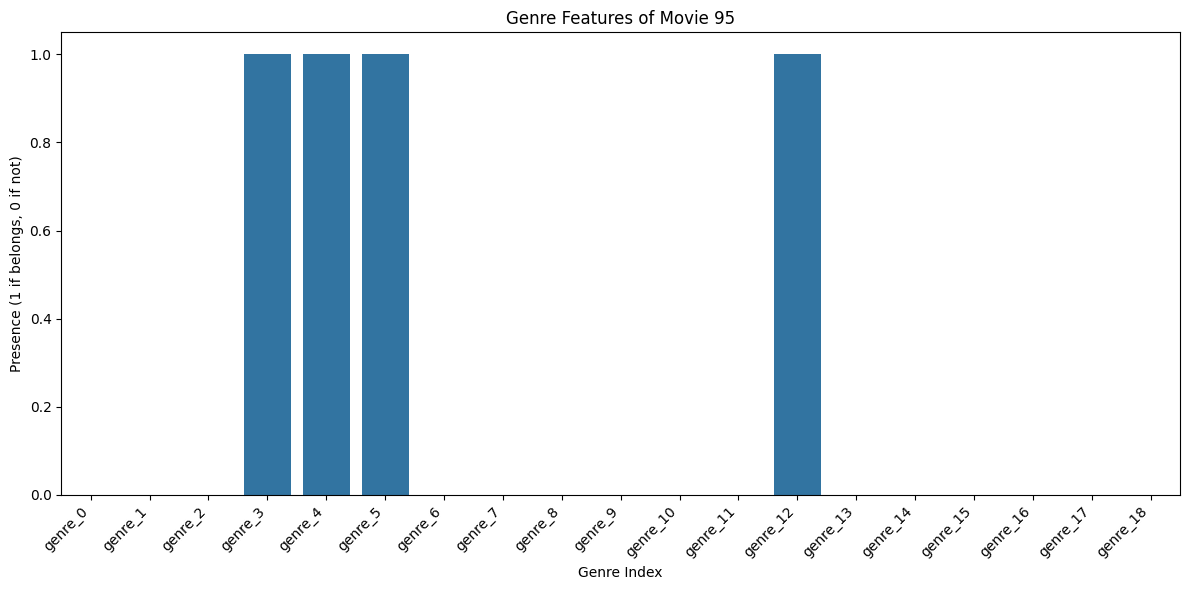

In [22]:
# --- 可视化 5: 电影 95 的类型特征 ---
item_95_vec_series = movie_genres.loc[95] # 提取 Series 方便绘图

plt.figure(figsize=(12, 6))
sns.barplot(x=item_95_vec_series.index, y=item_95_vec_series.values)
plt.title('Genre Features of Movie 95')
plt.xlabel('Genre Index')
plt.ylabel('Presence (1 if belongs, 0 if not)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("images/Genre Features of Movie 95.png")
plt.show()

In [13]:
# ——— 6. 计算余弦相似度与距离 ————————————————————————————————
sim_200 = cosine_similarity(profile_200_vec, item_95_vec)[0,0]
sim_15  = cosine_similarity(profile_15_vec,  item_95_vec)[0,0]
dist_200 = 1 - sim_200
dist_15  = 1 - sim_15

In [15]:
# ——— 7. 输出结果 ——————————————————————————————————————————
print(f"The cosine similarity between user 200 and movie 95:{sim_200:.4f}，distance：{dist_200:.4f}")
print(f"The cosine similarity between user 15 and movie 95:{sim_15:.4f}，distance：{dist_15:.4f}")

# 判断推荐：相似度越高，越应推荐
best_user = 200 if sim_200 > sim_15 else 15
print(f"\n→ This system is more inclined towards users {best_user} recommended movies 95")

The cosine similarity between user 200 and movie 95:-0.2652，distance：1.2652
The cosine similarity between user 15 and movie 95:-0.3259，distance：1.3259

→ This system is more inclined towards users 200 recommended movies 95
